In [1]:
%matplotlib inline

from analysis import *
from lomb import *
from matplotlib import pyplot as plt 
import numpy as np 
import matplotlib.image as mpimg
from tempfile import TemporaryFile
from scipy.optimize import minimize
from scipy.misc import factorial
from matplotlib.pyplot import ion


In [2]:
PMT, gt = PMTanalysis("data/dark.root")

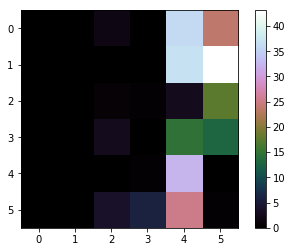

In [3]:
PMmean=[]
for i in range(36):
	PMmean.append(np.mean(PMT[i]))
PMmean=np.flipud((np.reshape(PMmean, (6,6))).T)
plt.figure()
img = plt.imshow(PMmean,interpolation='none')
img.set_cmap('cubehelix')
major_ticks = np.arange(0, 9, 1)                                              
plt.colorbar()

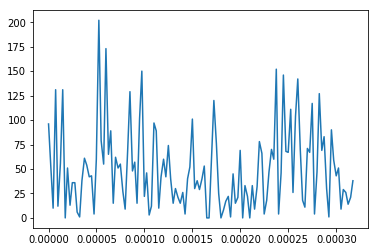

In [6]:
#plot the signal in 1 PMT for the first 128 GTU
plt.plot(gt[0:128], PMT[34][0:128])

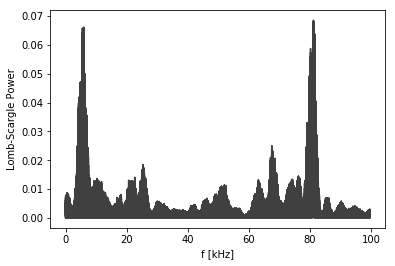

In [7]:
#Apply the lomb-scargle periodogram
from gatspy.periodic import LombScargleFast

nPMT = 34
model = LombScargleFast().fit(np.array(gt[0:1000]),np.array(PMT[nPMT][0:1000]))
periods, power = model.periodogram_auto(nyquist_factor=60)

fig, ax = plt.subplots()
ax.plot((1./periods)/1e3, power, color='0.25')
ax.set(xlabel='f [kHz]',
       ylabel='Lomb-Scargle Power');

In [8]:
#identify the periodic frequencies
model.optimizer.period_range=(1./65e3, 1./100e3)
period = model.best_period
freq = (1./period)
print("frequency [Hz] = {0}".format(freq))

Finding optimal frequency:
 - Estimated peak width = 20.9
 - Using 5 steps per peak; omega_step = 4.18
 - User-specified period range:  1e-05 to 1.5e-05
 - Computing periods at 52664 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
frequency [Hz] = 81203.1950531


134000.0


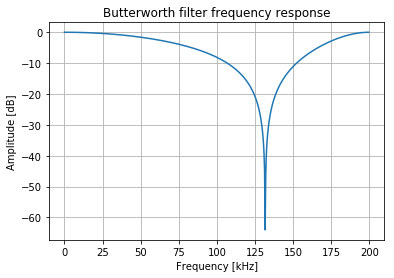

In [196]:
#design a bandstop filter for this frequency
from scipy import signal
#band freq normalised to nyquist 
#(digital filter)
fs=400e3 # 400 kHz sample frequency
nyquist=0.5*fs
freq=0.67*nyquist
#f1=80e3
fstart=((0.5)*freq)/nyquist
fstop=((1.3)*freq)/nyquist
print freq
#define the filter
b, a = signal.butter(1,[fstart,fstop],'bandstop')
#b, a = signal.butter(1, [2*np.pi*(freq+3e3),2*np.pi*(freq-3e3)], 'bandstop', analog=True)

#plot the filter
w, h = signal.freqz(b, a)

plt.plot((fs * 0.5 / np.pi) * w / 1e3, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [kHz]')
plt.ylabel('Amplitude [dB]')
plt.grid(which='both', axis='both')

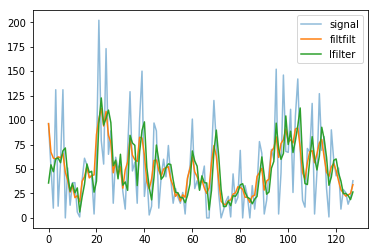

In [139]:
#apply the bandstop filter on real data
filt_sig1 = signal.filtfilt(b,a,PMT[nPMT][:], axis=-1)
filt_sig2 = signal.lfilter(b,a,PMT[nPMT][:], axis=-1)
#plot the result
plt.plot(PMT[nPMT][0:128], label = 'signal',alpha=0.5)
plt.plot(filt_sig1[0:128], label ='filtfilt')
plt.plot(filt_sig2[0:128], label ='lfilter')
plt.legend()

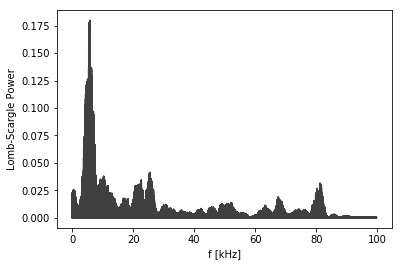

In [128]:
#use the lomb periodogram to search for periodicity 
#in the filtered signal
model = LombScargleFast().fit(np.array(gt[0:1000]),np.array(filt_sig2[0:1000]))
periods, power = model.periodogram_auto(nyquist_factor=60)

fig, ax = plt.subplots()
ax.plot((1./periods)/1e3, power, color='0.25')
ax.set(xlabel='f [kHz]',
       ylabel='Lomb-Scargle Power');

#high frequency components removed

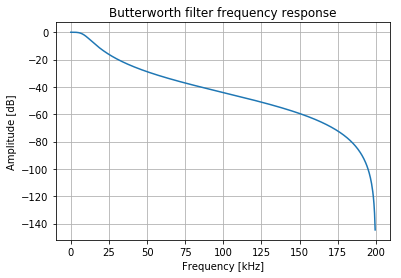

In [171]:
#try a lowpass filter for comparison
#threshold freq normalised to nyquist
f_thresh=10e3/nyquist # Try 10 kHz <=> 

#define the filter
b, a = signal.butter(2,f_thresh,'low')
#b, a = signal.butter(1, [2*np.pi*(freq+3e3),2*np.pi*(freq-3e3)], 'bandstop', analog=True)

#plot the filter
w, h = signal.freqz(b, a)
plt.plot((fs * 0.5 / np.pi) * w / 1e3, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [kHz]')
plt.ylabel('Amplitude [dB]')
plt.grid(which='both', axis='both')


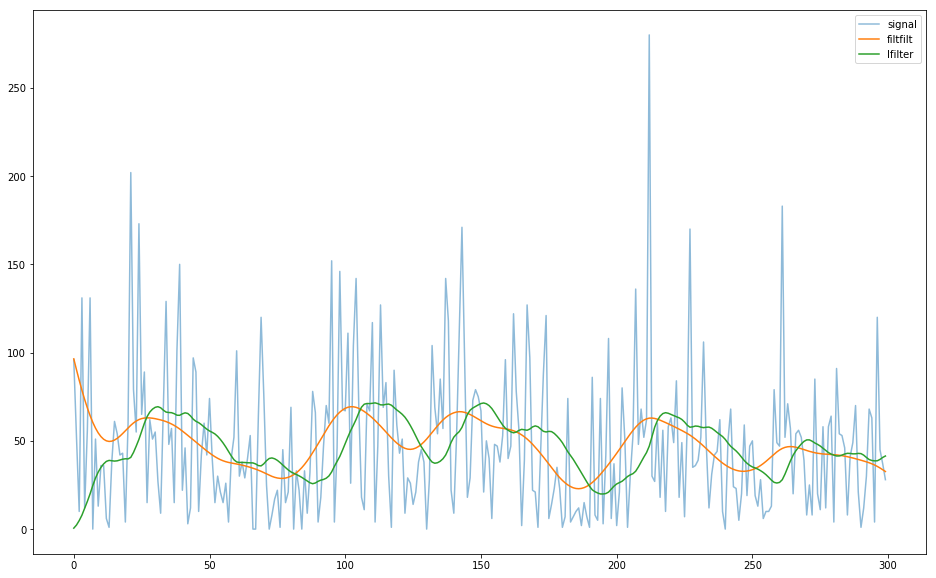

In [148]:
#apply the lowpass filter on real data
filt_sig1 = signal.filtfilt(b,a,PMT[nPMT][:], axis=-1)
filt_sig2 = signal.lfilter(b,a,PMT[nPMT][:], axis=-1)
#plot the result
plt.figure(figsize = [16,10])
plt.plot(PMT[nPMT][0:300], label = 'signal',alpha=0.5)
plt.plot(filt_sig1[0:300], label ='filtfilt')
plt.plot(filt_sig2[0:300], label ='lfilter')
plt.legend()

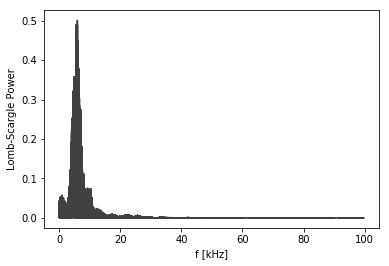

In [91]:
#use the lomb periodogram to search for periodicity 
#in the filtered signal
model = LombScargleFast().fit(np.array(gt[0:1000]),np.array(filt_sig2[0:1000]))
periods, power = model.periodogram_auto(nyquist_factor=60)

fig, ax = plt.subplots()
ax.plot((1./periods)/1e3, power, color='0.25')
ax.set(xlabel='f [kHz]',
       ylabel='Lomb-Scargle Power');

#high frequency components removed

In [149]:
#check an airshower signal
PMT_cr, gt_cr = PMTanalysis("data/allpackets-TA-ACQUISITION-20150513-080301-gaintable_20150510_1.txt-el15deg.root")

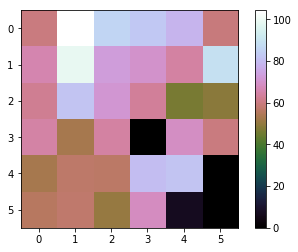

In [150]:
PMmean=[]
for i in range(36):
	PMmean.append(np.mean(PMT_cr[i]))
PMmean=np.flipud((np.reshape(PMmean, (6,6))).T)
plt.figure()
img = plt.imshow(PMmean,interpolation='none')
img.set_cmap('cubehelix')
major_ticks = np.arange(0, 9, 1)                                              
plt.colorbar()

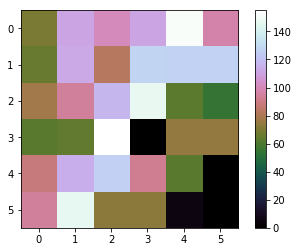

In [189]:
#plot for the GTU with air shower
gtu_event=284114
PMmean=[]
for i in range(36):
	PMmean.append(PMT_cr[i][gtu_event])
PMmean=np.flipud((np.reshape(PMmean, (6,6))).T)
plt.figure()
img = plt.imshow(PMmean,interpolation='none')
img.set_cmap('cubehelix')
major_ticks = np.arange(0, 9, 1)                                              
plt.colorbar()

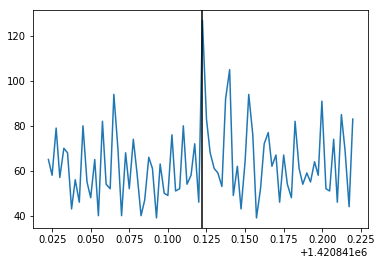

In [169]:
#plot the signal in 1 PMT for the first 128 GTU for dark vs light datasets
#plt.plot(gt[0:128], PMT[34][0:128], alpha=0.5)
#plt.plot(gt_cr[0:128], PMT_cr[34][0:128], alpha=0.5)

#now plot this PMT when during the CR event GTU # 284114
gtu_event=284114
pm=40
plt.plot(gt_cr[gtu_event-pm:gtu_event+pm]/1e-3, PMT_cr[28][gtu_event-pm:gtu_event+pm])
plt.axvline(gt_cr[gtu_event]/1e-3, color='k')

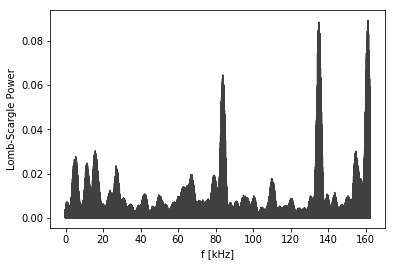

In [190]:
#identify dominant frequencies
#use the lomb periodogram to search for periodicity 
#in the filtered signal
model = LombScargleFast().fit(np.array(gt_cr[0:1000]),np.array(PMT_cr[nPMT][0:1000]))
periods, power = model.periodogram_auto(nyquist_factor=1200)

fig, ax = plt.subplots()
ax.plot((1./periods)/1e3, power, color='0.25')
ax.set(xlabel='f [kHz]',
       ylabel='Lomb-Scargle Power');


In [191]:
#identify the periodic frequencies
model.optimizer.period_range=(1./65e3, 1./200e3)
period = model.best_period
freq = (1./period)
print("frequency [Hz] = {0}".format(freq))

Finding optimal frequency:
 - Estimated peak width = 1.7
 - Using 5 steps per peak; omega_step = 0.34
 - User-specified period range:  5e-06 to 1.5e-05
 - Computing periods at 2494665 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
frequency [Hz] = 135266.675054


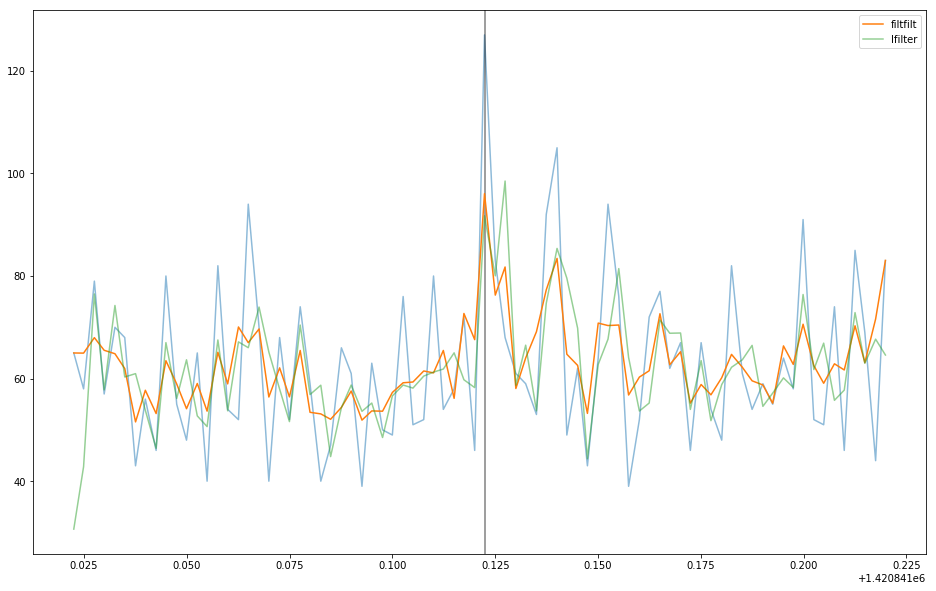

In [197]:
#try out filtering for this PMT
nPMT=28
filt_sig1 = signal.filtfilt(b,a,PMT_cr[nPMT][gtu_event-pm:gtu_event+pm], axis=-1)
filt_sig2 = signal.lfilter(b,a,PMT_cr[nPMT][gtu_event-pm:gtu_event+pm], axis=-1)
#plot the result
plt.figure(figsize = [16,10])
plt.plot(gt_cr[gtu_event-pm:gtu_event+pm]/1e-3, PMT_cr[28][gtu_event-pm:gtu_event+pm], alpha=0.5)
plt.axvline(gt_cr[gtu_event]/1e-3, color='k', alpha=0.5)
plt.plot(gt_cr[gtu_event-pm:gtu_event+pm]/1e-3, filt_sig1, label ='filtfilt')
plt.plot(gt_cr[gtu_event-pm:gtu_event+pm]/1e-3, filt_sig2, label ='lfilter', alpha=0.5)
plt.legend()

In [141]:
#now try to model the signal as a superposition of sine waves
#make a simple dataset
simple_sig = np.array(PMT[34][0:128])
simple_t = np.array(gt[0:128])

#try to guess the frequency
x=np.linspace(0,128,128)
f0=2 # low frequency component
f1=0.2*fs

y0= (np.sin(2*np.pi*f0*x)) + 100 
y1= (np.sin(2*np.pi*f1*x)) + 100
y=y0

#plt.figure(figsize=[16,10])
#plt.plot(simple_sig)
#plt.plot(y)

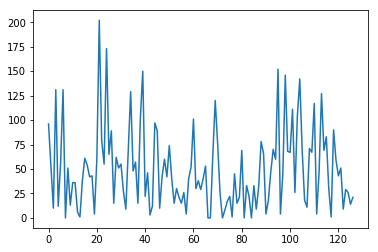

In [46]:
#check the boundaries in data
plt.plot(PMT[nPMT][0:127], '-')
#plt.plot(PMT[nPMT][128:255], '.')
#plt.plot(PMT[nPMT][256:383], '.')

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.


(54,)

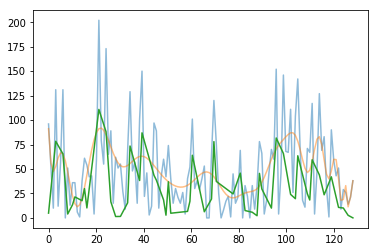

In [142]:
#try to fit the output
from scipy.optimize import curve_fit
#def fitFunc(X,a,b,c):
#   return ( a*np.sin(b*X + c))

#init_vals = [1,1,1]    
#best_vals, covar = curve_fit(fitFunc, x, simple_sig, p0=init_vals)
#plt.plot(x,fitFunc(simple_t,best_vals[0],best_vals[1], best_vals[2]), '-', color = 'k', lw = 1)
#print x
z=np.polyfit(x,simple_sig,110)
p=np.poly1d(z)
plt.plot(x,simple_sig, alpha=0.5)
plt.plot(x,p(x), alpha=0.5)
a=simple_sig-p(x)
plt.plot(x[a>0],a[a>0])
np.shape(a[a>0])
